In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

sample_rate = 250

# Load data from .txt file

In [82]:
df = pd.read_csv('data/raw_cell.txt', usecols=[1,2,3,4,9,10,11], skiprows=7, index_col=None, header=None)
data = df.to_numpy()
data = data.astype(float)

In [83]:
data.shape

(79710, 7)

# Filter the raw data
## Build your own filter

In [84]:
def bandpass(start, stop, data, sample_rate = 250):
    bp_Hz = np.array([start, stop])
    b, a = signal.butter(5, bp_Hz / (sample_rate / 2.0), btype='bandpass')
    return signal.lfilter(b, a, data, axis=0)

def notch(val, data, sample_rate= 250):
    notch_freq_Hz = np.array([float(val)])
    for freq_Hz in np.nditer(notch_freq_Hz):
        bp_stop_Hz = freq_Hz + 3.0 * np.array([-1, 1])
        b, a = signal.butter(3, bp_stop_Hz / (sample_rate / 2.0), 'bandstop')
        fin = data = signal.lfilter(b, a, data)
    return fin

def fft(data, sample_rate):
    L = len(data)
    freq = np.linspace(0.0, 1.0 / (2.0 * sample_rate **-1), L // 2)
    yi = np.fft.fft(data)[1:]
    y = yi[range(int(L / 2))]
    return freq, abs(y)

## Plot the raw data

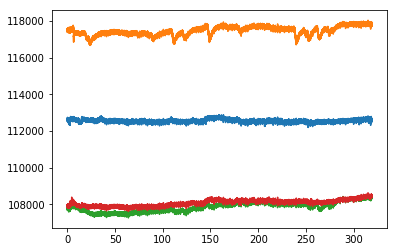

In [85]:
# raw channels
channels = []
for i in range(4):
    channels.append(data[:,i].astype(np.float))
t = len(channels[0])/sample_rate
time = np.linspace(0, t, len(channels[0]))
for i in range(len(channels)):
    plt.plot(time,channels[i])

(0, 100)

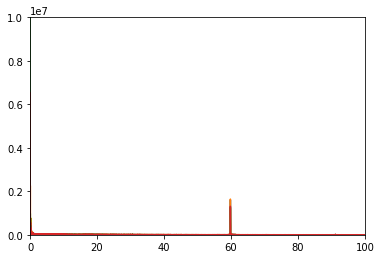

In [86]:
# fft of raw channels
for i in range(len(channels)):
    freq, y = fft(channels[i], sample_rate)
    plt.plot(freq, y)
plt.ylim(0, 1e7)
plt.xlim(0,100)

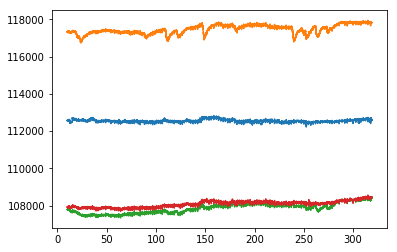

In [87]:
#applied notch filter = 60
notch_channels = []
for i in range(len(channels)):
    notch_channels.append(notch(60,channels[i], sample_rate = sample_rate))
for i in range(len(notch_channels)):
    plt.plot(time[10*sample_rate:], notch_channels[i][10*sample_rate:])

(0, 100)

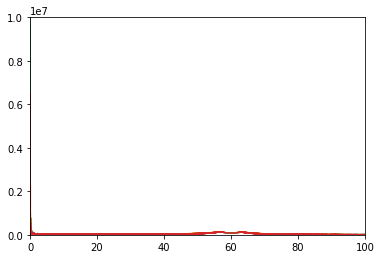

In [88]:
# fft of applied notch
for i in range(len(notch_channels)):
    freq, y = fft(notch_channels[i], sample_rate)
    plt.plot(freq, y)
plt.ylim(0, 1e7)
plt.xlim(0,100)

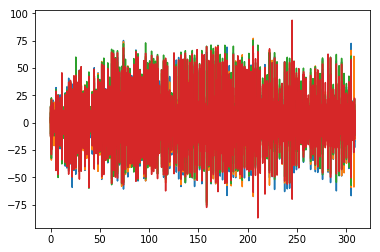

In [101]:
#applied bandpass filter = 6-25
band = (6,25)
bandpass_channels = []
for i in range(len(notch_channels)):
    bandpass_channels.append(bandpass(band[0],band[1],notch_channels[i], sample_rate = sample_rate))

#remove 10 seconds' data
final_channels = []
for i in range(len(bandpass_channels)):
    final_channels.append(bandpass_channels[i][int(10*sample_rate):])

t = len(final_channels[0])/sample_rate
time = np.linspace(0, t, len(final_channels[0]))
  
    
    
for i in range(len(bandpass_channels)):
    plt.plot(time, final_channels[i])
#plt.xlim(0,10)

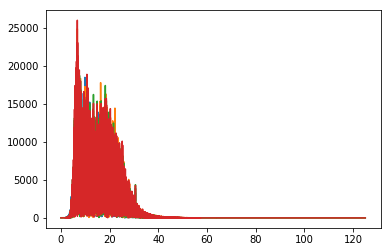

In [102]:
# fft of applied bandpass
for i in range(len(final_channels)):
    freq, y = fft(final_channels[i], sample_rate)
    plt.plot(freq, y)
#plt.ylim(0, 1e7)
#plt.xlim(0,100)

In [64]:
bandpass_channels[1][2]

46627.69021645636